In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_context('paper')

# Util function: line seperator
def print_ln():
    print('-' * 80, '\n')


# Function to create a subset of the dataframe
def subset(dataframe, col_name, col_names_list):
    return dataframe.loc[dataframe[col_name].isin(col_names_list)]


In [24]:
def func_numeric(df, col_name):
    df[col_name] = df[col_name].astype(float)
    return df


In [25]:
def func_rename(df):
    old_col_names = df.columns.to_list()
    new_col_names = []
    for a_col_name in old_col_names:
        col_name = a_col_name + "_score"
        new_col_names.append(col_name)

    name_pairs = dict(zip(old_col_names, new_col_names))
    df = df.rename(columns=name_pairs)
    return df


In [26]:
def negative_zscore(dataframe):
    df = dataframe.copy()
    cols = list(df.columns)
    for col in cols:
        df[col] = - (df[col] - df[col].mean())/df[col].std(ddof=0)
    return df


def positive_zscore(dataframe):
    df = dataframe.copy()
    cols = list(df.columns)
    for col in cols:
        df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    return df


In [27]:
def subset_by_iqr(df, column, whisker_width=0):
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.00125)
    q3 = df[column].quantile(0.99875)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter][column]

#df_filtered = subset_by_iqr(df, 'READM_30_STK_score')
#df_filtered

def treat_outliers(dataframe):
    df = dataframe.copy()
    cols = list(df.columns)
    for col in cols:
        df[col] = subset_by_iqr(df, col)
    return df


In [28]:

read_rawdata = pd.read_csv("Readmissions and Deaths - Hospital.csv",
                           encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])

read_rawdata.shape


(67452, 18)

In [29]:
read_rawdata.head(10)


,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Compared to National,Denominator,Score,Lower Estimate,Higher Estimate,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Myocardial Infarction (AMI) 30-Day Morta...,MORT_30_AMI,No Different than the National Rate,733.0,12.5,10.6,14.9,NaN,07/01/2012,06/30/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for CABG,MORT_30_CABG,No Different than the National Rate,278.0,4.2,2.6,6.8,NaN,07/01/2012,06/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for chronic obstructive pulmonary d...,MORT_30_COPD,No Different than the National Rate,586.0,9.3,7.3,11.8,NaN,07/01/2012,06/30/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart failure (HF) 30-Day Mortality Rate,MORT_30_HF,No Different than the National Rate,797.0,12.4,10.4,14.6,NaN,07/01/2012,06/30/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Pneumonia (PN) 30-Day Mortality Rate,MORT_30_PN,No Different than the National Rate,599.0,15.5,13.0,18.5,NaN,07/01/2012,06/30/2015
5,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for stroke patients,MORT_30_STK,No Different than the National Rate,512.0,15.4,12.8,18.6,NaN,07/01/2012,06/30/2015
6,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Myocardial Infarction (AMI) 30-Day Readm...,READM_30_AMI,No Different than the National Rate,781.0,16.5,14.6,18.8,NaN,07/01/2012,06/30/2015
7,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Rate of readmission for CABG,READM_30_CABG,No Different than the National Rate,273.0,15.1,12.3,18.5,NaN,07/01/2012,06/30/2015
8,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Rate of readmission for chronic obstructive pu...,READM_30_COPD,No Different than the National Rate,707.0,21.1,18.7,23.8,NaN,07/01/2012,06/30/2015
9,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart failure (HF) 30-Day Readmission Rate,READM_30_HF,No Different than the National Rate,981.0,21.4,19.2,23.7,NaN,07/01/2012,06/30/2015


In [30]:
read_rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67452 entries, 0 to 67451
Data columns (total 18 columns):
Provider ID             67452 non-null int64
Hospital Name           67452 non-null object
Address                 67452 non-null object
City                    67452 non-null object
State                   67452 non-null object
ZIP Code                67452 non-null int64
County Name             67242 non-null object
Phone Number            67452 non-null int64
Measure Name            67452 non-null object
Measure ID              67452 non-null object
Compared to National    52902 non-null object
Denominator             41710 non-null float64
Score                   41710 non-null float64
Lower Estimate          41710 non-null float64
Higher Estimate         41710 non-null float64
Footnote                25742 non-null object
Measure Start Date      67452 non-null object
Measure End Date        67452 non-null object
dtypes: float64(4), int64(3), object(11)
memory usage: 9.3+ MB

In [31]:
read_rawdata['Score'].unique()


array([12.5,  4.2,  9.3, 12.4, 15.5, 15.4, 16.5, 15.1, 21.1, 21.4,  5.1,
       18.7, 12.7, 16. ,  nan,  7.6, 20.8, 16.7, 18. , 21.9,  5.7, 14.9,
       16.4, 13.4,  4.1,  7.1, 15.6, 18.2, 17.9, 16.1, 15.2, 19.8, 20.6,
        5. , 12. , 14.4, 18.8, 16.6, 19.9, 17.3,  8.2, 15.7, 19.2, 23.1,
       13.9,  3.7,  7.4, 13.8, 12.6, 17.7, 15. , 19.6, 15.3, 11.3, 16.8,
        9.2, 26.8, 15.8, 23.4, 19.4, 12.8, 14.7,  3.6,  8.1, 14. , 21.5,
       17.1,  8.7, 12.9, 19.1, 23. , 22.4, 15.9, 18.3, 13.5,  6.4, 12.2,
       14.3, 21.3, 14.8,  7.7,  4.5,  9.1, 18.1, 19.5, 23.3,  4.7, 18.6,
        4.8,  9.5, 10.6, 17.2, 19. ,  4.9, 16.9, 13. ,  4.4,  8. , 12.1,
       23.2,  5.9, 10.5, 21.6, 16.3,  2.3, 18.9, 23.7,  7. ,  9.4, 20.1,
       21.7,  8.3, 20.2, 16.2, 22.8,  4.6,  7.2, 11.5, 13.2,  3.9, 14.5,
       20.3, 24. , 13.1,  1.8, 11.7, 13.7, 12.3,  7.5, 19.7, 21. ,  6.7,
        6.6, 11.4, 10.7, 17.4, 22.2, 11.2,  3.1,  7.8, 14.2, 22.3, 17.5,
       14.6, 20. , 11.6, 13.6, 22.5,  4.3, 10.4, 20

In [32]:
read_meas_list =   ["READM_30_AMI", "READM_30_CABG", "READM_30_COPD", "READM_30_HF", "READM_30_HIP_KNEE", "READM_30_HOSP_WIDE", "READM_30_PN", "READM_30_STK"]
read_meas_list

['READM_30_AMI',
 'READM_30_CABG',
 'READM_30_COPD',
 'READM_30_HF',
 'READM_30_HIP_KNEE',
 'READM_30_HOSP_WIDE',
 'READM_30_PN',
 'READM_30_STK']

In [33]:
read_hosp = read_rawdata.iloc[:,0:8]
read_hosp.head(5)

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701


In [34]:
read_hosp = read_hosp.drop_duplicates(keep='first')
read_hosp

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701
14,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310
28,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400
42,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541
56,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374
70,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122
84,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150
98,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100
112,10018,CALLAHAN EYE HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100
126,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,AL,35660,COLBERT,2563864556


In [35]:
read_meas = read_rawdata.iloc[: , [0,9,12]]
read_meas

print_ln()
read_meas.info()

print_ln()
read_meas.dtypes

-------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67452 entries, 0 to 67451
Data columns (total 3 columns):
Provider ID    67452 non-null int64
Measure ID     67452 non-null object
Score          41710 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.5+ MB
-------------------------------------------------------------------------------- 



Provider ID      int64
Measure ID      object
Score          float64
dtype: object

In [36]:
read_meas['Score'] = read_meas['Score'].astype(float)
read_meas.dtypes

print_ln()
read_meas

-------------------------------------------------------------------------------- 



,Provider ID,Measure ID,Score
0,10001,MORT_30_AMI,12.5
1,10001,MORT_30_CABG,4.2
2,10001,MORT_30_COPD,9.3
3,10001,MORT_30_HF,12.4
4,10001,MORT_30_PN,15.5
5,10001,MORT_30_STK,15.4
6,10001,READM_30_AMI,16.5
7,10001,READM_30_CABG,15.1
8,10001,READM_30_COPD,21.1
9,10001,READM_30_HF,21.4


In [37]:
read_meas = read_meas.loc[read_meas['Measure ID'].isin(read_meas_list)]
read_meas

,Provider ID,Measure ID,Score
6,10001,READM_30_AMI,16.5
7,10001,READM_30_CABG,15.1
8,10001,READM_30_COPD,21.1
9,10001,READM_30_HF,21.4
10,10001,READM_30_HIP_KNEE,5.1
11,10001,READM_30_HOSP_WIDE,15.4
12,10001,READM_30_PN,18.7
13,10001,READM_30_STK,12.7
20,10005,READM_30_AMI,16.7
21,10005,READM_30_CABG,NaN


In [38]:
read_meas_score = read_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
print_ln()
read_meas_score.columns
print_ln()
read_meas_score
print_ln()
read_meas_score.dtypes
print_ln()
read_meas_score.info()

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 10001 to 670112
Data columns (total 8 columns):
READM_30_AMI          2163 non-null float64
READM_30_CABG         1027 non-null float64
READM_30_COPD         3648 non-null float64
READM_30_HF           3650 non-null float64
READM_30_HIP_KNEE     2731 non-null float64
READM_30_HOSP_WIDE    4395 non-null float64
READM_30_PN           4089 non-null float64
READM_30_STK          2608 non-null float64
dtypes: float64(8)
memory usage: 338.8 KB


In [39]:
read_meas_score =  func_rename(read_meas_score)
read_meas_score



Measure ID,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score
Provider ID,,,,,,,,
10001,16.5,15.1,21.1,21.4,5.1,15.4,18.7,12.7
10005,16.7,NaN,18.0,21.9,5.7,14.9,16.4,13.4
10006,16.1,15.2,19.8,20.6,5.0,15.4,17.9,12.0
10007,NaN,NaN,19.9,21.1,NaN,16.6,17.3,12.7
10008,NaN,NaN,19.2,23.1,NaN,15.7,16.0,NaN
10011,17.7,15.0,19.6,19.8,5.1,15.3,16.7,11.3
10012,16.1,NaN,19.2,23.4,NaN,15.3,19.4,12.8
10016,17.7,15.8,17.9,21.5,5.0,14.7,17.1,12.4
10018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
np.nansum(read_meas_score['READM_30_AMI_score'].unique())


1104.3

In [41]:
readmission = negative_zscore(read_meas_score)
print_ln()
readmission


-------------------------------------------------------------------------------- 



Measure ID,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score
Provider ID,,,,,,,,
10001,0.408730,-0.615156,-0.866907,0.370423,-0.884170,0.215408,-1.105482,-0.124569
10005,0.199974,NaN,1.574551,0.036453,-1.968440,0.820649,0.495640,-0.777118
10006,0.826243,-0.703937,0.156930,0.904776,-0.703459,0.215408,-0.548570,0.527980
10007,NaN,NaN,0.078174,0.570805,NaN,-1.237171,-0.130886,-0.124569
10008,NaN,NaN,0.629471,-0.765075,NaN,-0.147737,0.774096,NaN
10011,-0.843809,-0.526375,0.314444,1.439128,-0.884170,0.336456,0.286798,1.180529
10012,0.826243,NaN,0.629471,-0.965457,NaN,0.336456,-1.592780,-0.217790
10016,-0.843809,-1.236623,1.653308,0.303629,-0.703459,1.062745,0.008342,0.155095
10018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:

readmission = treat_outliers(readmission)
readmission

Measure ID,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score
Provider ID,,,,,,,,
10001,0.408730,-0.615156,-0.866907,0.370423,-0.884170,0.215408,-1.105482,-0.124569
10005,0.199974,NaN,1.574551,0.036453,-1.968440,0.820649,0.495640,-0.777118
10006,0.826243,-0.703937,0.156930,0.904776,-0.703459,0.215408,-0.548570,0.527980
10007,NaN,NaN,0.078174,0.570805,NaN,-1.237171,-0.130886,-0.124569
10008,NaN,NaN,0.629471,-0.765075,NaN,-0.147737,0.774096,NaN
10011,-0.843809,-0.526375,0.314444,1.439128,-0.884170,0.336456,0.286798,1.180529
10012,0.826243,NaN,0.629471,-0.965457,NaN,0.336456,-1.592780,-0.217790
10016,-0.843809,-1.236623,1.653308,0.303629,-0.703459,1.062745,0.008342,0.155095
10018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
read_master = pd.merge(read_hosp, readmission, on="Provider ID")
read_master.info()
print_ln()
read_master.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 0 to 4817
Data columns (total 16 columns):
Provider ID                 4818 non-null int64
Hospital Name               4818 non-null object
Address                     4818 non-null object
City                        4818 non-null object
State                       4818 non-null object
ZIP Code                    4818 non-null int64
County Name                 4803 non-null object
Phone Number                4818 non-null int64
READM_30_AMI_score          2157 non-null float64
READM_30_CABG_score         1023 non-null float64
READM_30_COPD_score         3640 non-null float64
READM_30_HF_score           3640 non-null float64
READM_30_HIP_KNEE_score     2723 non-null float64
READM_30_HOSP_WIDE_score    4383 non-null float64
READM_30_PN_score           4077 non-null float64
READM_30_STK_score          2601 non-null float64
dtypes: float64(8), int64(3), object(5)
memory usage: 639.9+ KB
----------------------------------------

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.615156,-0.866907,0.370423,-0.884170,0.215408,-1.105482,-0.124569
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,NaN,1.574551,0.036453,-1.968440,0.820649,0.495640,-0.777118
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,-0.703937,0.156930,0.904776,-0.703459,0.215408,-0.548570,0.527980
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,NaN,0.078174,0.570805,NaN,-1.237171,-0.130886,-0.124569
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,NaN,0.629471,-0.765075,NaN,-0.147737,0.774096,NaN


In [44]:
readmission.to_csv("cleaned_readmission_data_py.csv")


In [45]:
mort_rawdata1 = read_rawdata
mort_rawdata1.shape
print_ln()

mort_rawdata2 = pd.read_csv("Complications - Hospital.csv", encoding="ISO-8859-1", na_values=["Not Available", "Not Applicable"])
mort_rawdata2.shape
print_ln()

mort_rawdata2.columns
mort_rawdata2.columns
print_ln()

mort_rawdata1.columns == mort_rawdata2.columns

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [46]:
mort_rawdata = pd.concat([mort_rawdata1, mort_rawdata2])
mort_rawdata.shape
print_ln()


mort_rawdata

-------------------------------------------------------------------------------- 



,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Compared to National,Denominator,Score,Lower Estimate,Higher Estimate,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Myocardial Infarction (AMI) 30-Day Morta...,MORT_30_AMI,No Different than the National Rate,733.0,12.5,10.6,14.9,NaN,07/01/2012,06/30/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for CABG,MORT_30_CABG,No Different than the National Rate,278.0,4.2,2.6,6.8,NaN,07/01/2012,06/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for chronic obstructive pulmonary d...,MORT_30_COPD,No Different than the National Rate,586.0,9.3,7.3,11.8,NaN,07/01/2012,06/30/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart failure (HF) 30-Day Mortality Rate,MORT_30_HF,No Different than the National Rate,797.0,12.4,10.4,14.6,NaN,07/01/2012,06/30/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Pneumonia (PN) 30-Day Mortality Rate,MORT_30_PN,No Different than the National Rate,599.0,15.5,13.0,18.5,NaN,07/01/2012,06/30/2015
5,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for stroke patients,MORT_30_STK,No Different than the National Rate,512.0,15.4,12.8,18.6,NaN,07/01/2012,06/30/2015
6,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Myocardial Infarction (AMI) 30-Day Readm...,READM_30_AMI,No Different than the National Rate,781.0,16.5,14.6,18.8,NaN,07/01/2012,06/30/2015
7,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Rate of readmission for CABG,READM_30_CABG,No Different than the National Rate,273.0,15.1,12.3,18.5,NaN,07/01/2012,06/30/2015
8,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Rate of readmission for chronic obstructive pu...,READM_30_COPD,No Different than the National Rate,707.0,21.1,18.7,23.8,NaN,07/01/2012,06/30/2015
9,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart failure (HF) 30-Day Readmission Rate,READM_30_HF,No Different than the National Rate,981.0,21.4,19.2,23.7,NaN,07/01/2012,06/30/2015


In [47]:
mort_meas_list =   ["MORT_30_AMI", "MORT_30_CABG", "MORT_30_COPD", "MORT_30_HF", "MORT_30_PN", "MORT_30_STK", "PSI_4_SURG_COMP"]
mort_meas_list
print_ln()

mort_hosp = mort_rawdata.iloc[:,0:8]

mort_hosp = mort_hosp.drop_duplicates(keep='first')
mort_hosp
print_ln()

mort_hosp.dtypes

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



Provider ID       int64
Hospital Name    object
Address          object
City             object
State            object
ZIP Code          int64
County Name      object
Phone Number      int64
dtype: object

In [48]:
mort_meas = mort_rawdata.iloc[: , [0,9,12]]
mort_meas.dtypes
print_ln()
mort_meas

-------------------------------------------------------------------------------- 



,Provider ID,Measure ID,Score
0,10001,MORT_30_AMI,12.5
1,10001,MORT_30_CABG,4.2
2,10001,MORT_30_COPD,9.3
3,10001,MORT_30_HF,12.4
4,10001,MORT_30_PN,15.5
5,10001,MORT_30_STK,15.4
6,10001,READM_30_AMI,16.5
7,10001,READM_30_CABG,15.1
8,10001,READM_30_COPD,21.1
9,10001,READM_30_HF,21.4


In [49]:
mort_meas = mort_meas.loc[mort_meas['Measure ID'].isin(mort_meas_list)]
mort_meas
print_ln()

mort_meas.dtypes
print_ln()

mort_meas = func_numeric(mort_meas, 'Score')
mort_meas.dtypes
print_ln()


-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [50]:

mort_meas_score = mort_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
mort_meas_score
print_ln()

mort_meas_score = func_rename(mort_meas_score)
mort_meas_score
print_ln()

mort_meas_score.columns
print_ln()
mort_meas_score
print_ln()
mort_meas_score.dtypes
print_ln()
mort_meas_score.info()


-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 10001 to 670112
Data columns (total 7 columns):
MORT_30_AMI_score        2388 non-null float64
MORT_30_CABG_score       1038 non-null float64
MORT_30_COPD_score       3591 non-null float64
MORT_30_HF_score         3618 non-null float64
MORT_30_PN_score         4088 non-null float64
MORT_30_STK_score        2676 non-null float64
PSI_4_SURG_COMP_score    1818 non-null float64
dtypes: float64(7)
memory usage: 301.1 KB


In [51]:
mortality = mort_meas_score
mortality
print_ln()

mortality = negative_zscore(mortality)
mortality
print_ln()



-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [52]:

mortality = treat_outliers(mortality)
mortality
print_ln()

mort_master = pd.merge(mort_hosp, mortality, on="Provider ID")
mort_master.info()
print_ln()
mort_master.head()

mortality.to_csv("cleaned_mortality_data_py.csv")

-------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 0 to 4817
Data columns (total 15 columns):
Provider ID              4818 non-null int64
Hospital Name            4818 non-null object
Address                  4818 non-null object
City                     4818 non-null object
State                    4818 non-null object
ZIP Code                 4818 non-null int64
County Name              4803 non-null object
Phone Number             4818 non-null int64
MORT_30_AMI_score        2382 non-null float64
MORT_30_CABG_score       1034 non-null float64
MORT_30_COPD_score       3583 non-null float64
MORT_30_HF_score         3609 non-null float64
MORT_30_PN_score         4076 non-null float64
MORT_30_STK_score        2668 non-null float64
PSI_4_SURG_COMP_score    1812 non-null float64
dtypes: float64(7), int64(3), object(5)
memory usage: 602.2+ KB
----------------------------------------------------

In [53]:
safe_rawdata1 = mort_rawdata
safe_rawdata1
print_ln()

safe_rawdata2 = pd.read_csv("Healthcare Associated Infections - Hospital.csv", encoding="ISO-8859-1", na_values=["Not Available", "Not Applicable"])
safe_rawdata2
print_ln()


-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [54]:
safe_rawdata1 = safe_rawdata1.iloc[: , [0,1, 2, 3, 4, 5, 6, 7, 9, 12]]
safe_rawdata1.columns
print_ln()
safe_rawdata1
print_ln()

safe_rawdata2 = safe_rawdata2.iloc[: , [0,1, 2, 3, 4, 5, 6, 7, 9, 11]]
safe_rawdata2.columns
print_ln()
safe_rawdata2
print_ln()

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [55]:
safe_rawdata1.columns == safe_rawdata2.columns


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [56]:
safe_rawdata = pd.concat([safe_rawdata1, safe_rawdata2])
safe_meas_list =   ["HAI_1_SIR", "HAI_2_SIR", "HAI_3_SIR", "HAI_4_SIR", "HAI_5_SIR", "HAI_6_SIR", "COMP_HIP_KNEE", "PSI_90_SAFETY"]
safe_hosp = safe_rawdata.iloc[:,0:8]
safe_hosp = safe_hosp.drop_duplicates(keep='first')
safe_hosp
print_ln()
safe_hosp.dtypes

-------------------------------------------------------------------------------- 



Provider ID       int64
Hospital Name    object
Address          object
City             object
State            object
ZIP Code          int64
County Name      object
Phone Number      int64
dtype: object

In [57]:
safe_rawdata.columns
print_ln()

safe_meas = safe_rawdata.iloc[: , [0,8,9]]
safe_meas
print_ln()

safe_meas = safe_meas.loc[safe_meas['Measure ID'].isin(safe_meas_list)]
safe_meas
safe_meas.dtypes
print_ln()

safe_meas = func_numeric(safe_meas, 'Score')
safe_meas.dtypes
print_ln()

safe_meas_score = safe_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
safe_meas_score
print_ln()

safe_meas_score = func_rename(safe_meas_score)
safe_meas_score
print_ln()

safety = safe_meas_score
safety
print_ln()


-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [58]:

safety = negative_zscore(safety)
safety
print_ln()

safety = treat_outliers(safety)
safety
print_ln()

safe_master = pd.merge(mort_hosp, safety, on="Provider ID")
safe_master
print_ln()

safety.to_csv("cleaned_safety_data_py.csv")

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [59]:

expe_rawdata = pd.read_csv("HCAHPS - Hospital.csv", encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])
expe_rawdata
expe_rawdata.columns
print_ln()

expe_new_col_names = {"HCAHPS Question": "Measure Name",
                      "HCAHPS Measure ID": "Measure ID",
                      "HCAHPS Linear Mean Value": "Score"}

expe_rawdata = expe_rawdata.rename(columns=expe_new_col_names)
expe_rawdata.columns
print_ln()


expe_meas_list = ["H_CLEAN_LINEAR_SCORE", "H_COMP_1_LINEAR_SCORE", "H_COMP_2_LINEAR_SCORE", "H_COMP_3_LINEAR_SCORE",
                  "H_COMP_4_LINEAR_SCORE", "H_COMP_5_LINEAR_SCORE", "H_COMP_6_LINEAR_SCORE", "H_COMP_7_LINEAR_SCORE",
                  "H_HSP_RATING_LINEAR_SCORE", "H_QUIET_LINEAR_SCORE", "H_RECMND_LINEAR_SCORE"]


expe_hosp = expe_rawdata.iloc[:, 0:8]
expe_hosp
print_ln()
expe_hosp.dtypes


expe_hosp = expe_hosp.drop_duplicates(keep='first')
expe_hosp
print_ln()
expe_hosp.dtypes

expe_meas = expe_rawdata.iloc[:, [0, 8, 15]]
expe_meas
print_ln()

expe_meas = expe_meas.loc[expe_meas['Measure ID'].isin(expe_meas_list)]
expe_meas
expe_meas.dtypes
print_ln()

expe_meas = func_numeric(expe_meas, 'Score')
expe_meas.dtypes
print_ln()

expe_meas_score = expe_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
expe_meas_score.dtypes
expe_meas_score
print_ln()


expe_meas_score = func_rename(expe_meas_score)
expe_meas_score
print_ln()


experience = expe_meas_score
experience
print_ln()

experience = positive_zscore(experience)
experience
print_ln()

experience = treat_outliers(experience)
experience
print_ln()

expe_master = pd.merge(expe_hosp, experience, on="Provider ID")
expe_master
print_ln()

experience.to_csv("cleaned_experience_data_py.csv")


-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

----

In [60]:
medi_rawdata = pd.read_csv("Outpatient Imaging Efficiency - Hospital.csv", encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])

medi_meas_list = ["OP_10", "OP_11", "OP_13", "OP_14", "OP_8"]

medi_hosp = medi_rawdata.iloc[:, 0:8]
medi_hosp
print_ln()
medi_hosp.dtypes

medi_hosp = medi_hosp.drop_duplicates(keep='first')
medi_hosp
print_ln()
medi_hosp.dtypes

medi_meas = medi_rawdata.iloc[:, [0, 8, 10]]
medi_meas
print_ln()

medi_meas = subset(medi_meas, 'Measure ID', medi_meas_list)
medi_meas
medi_meas.dtypes
print_ln()

medi_meas = func_numeric(medi_meas, 'Score')
medi_meas.dtypes
print_ln()


medi_meas_score = medi_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
medi_meas_score
print_ln()

medi_meas_score = func_rename(medi_meas_score)
medi_meas_score
print_ln()


medical = medi_meas_score
medical
print_ln()

medical = negative_zscore(medical)
medical
print_ln()

medical = treat_outliers(medical)
medical
print_ln()

medi_master = pd.merge(medi_hosp, medical, on="Provider ID")
medi_master
print_ln()

medical.to_csv("cleaned_medical_data_py.csv")


-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [61]:

time_rawdata = pd.read_csv("Timely and Effective Care - Hospital.csv", encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])
time_rawdata
print_ln()

time_meas_list = ["ED_1b", "ED_2b", "OP_18b", "OP_20", "OP_21", "OP_3b", "OP_5"]

time_hosp = time_rawdata.iloc[:, 0:8]
time_hosp
print_ln()
time_hosp.dtypes


time_hosp = time_hosp.drop_duplicates(keep='first')
time_hosp
print_ln()
time_hosp.dtypes

time_meas = time_rawdata.iloc[:, [0, 9, 11]]
time_meas
print_ln()


time_meas = subset(time_meas, 'Measure ID', time_meas_list)
time_meas
time_meas.dtypes
print_ln()

time_meas = func_numeric(time_meas, 'Score')
time_meas.dtypes
print_ln()

time_meas_score = time_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
time_meas_score
print_ln()

time_meas_score = func_rename(time_meas_score)
time_meas_score
print_ln()

timeliness = time_meas_score
timeliness
print_ln()

timeliness = negative_zscore(timeliness)
timeliness
print_ln()

timeliness = treat_outliers(timeliness)
timeliness
print_ln()

time_master = pd.merge(time_hosp, timeliness, on="Provider ID")
time_master
print_ln()

timeliness.to_csv("cleaned_timeliness_data_py.csv")




-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [62]:

effe_rawdata = time_rawdata
effe_rawdata
print_ln()

effe_meas_list = ["CAC_3", "IMM_2", "IMM_3_OP_27_FAC_ADHPCT", "OP_22", "OP_23", "OP_29", "OP_30", "OP_4", "PC_01", "STK_4", "STK_5", "STK_6", "STK_8", "VTE_1", "VTE_2", "VTE_3", "VTE_5", "VTE_6"]

effe_hosp = effe_rawdata.iloc[:, 0:8]
effe_hosp
print_ln()
effe_hosp.dtypes


effe_hosp = effe_hosp.drop_duplicates(keep='first')
effe_hosp
print_ln()
effe_hosp.dtypes

effe_meas = effe_rawdata.iloc[:, [0, 9, 11]]
effe_meas
print_ln()


effe_meas = subset(effe_meas, 'Measure ID', effe_meas_list)
effe_meas
effe_meas.dtypes
print_ln()

effe_meas = func_numeric(effe_meas, 'Score')
effe_meas.dtypes
print_ln()

effe_meas_score = effe_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
effe_meas_score
print_ln()


effe_meas_score = func_rename(effe_meas_score)
effe_meas_score
print_ln()

effectiveness = effe_meas_score
effectiveness
print_ln()

positive_measures = [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16]
effectiveness.iloc[:, positive_measures] = positive_zscore(effectiveness.iloc[:, positive_measures])
effectiveness.iloc[:, positive_measures].columns
print_ln()

negative_measures = [3, 8, 17]
effectiveness.iloc[:, negative_measures] = negative_zscore(effectiveness.iloc[:, negative_measures])
effectiveness.iloc[:, negative_measures].columns
print_ln()

effectiveness = treat_outliers(effectiveness)
effectiveness
print_ln()

effe_master = pd.merge(effe_hosp, effectiveness, on="Provider ID")
effe_master
print_ln()

effectiveness.to_csv("cleaned_effectiveness_data_py.csv")



-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

----

In [63]:

merge1 = pd.merge(read_master, mort_master)
merge2 = pd.merge(merge1, safe_master)
merge3 = pd.merge(merge2, expe_master)
merge4 = pd.merge(merge3, medi_master)
merge5 = pd.merge(merge4, time_master)
merge6 = pd.merge(merge5, effe_master)

print(merge6.columns.to_list)
print_ln()

merge6
print_ln()

master_data_x = merge6

master_data_x.to_csv("cleaned_master_data_x_py.csv")


<bound method IndexOpsMixin.tolist of Index(['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'READM_30_AMI_score',
       'READM_30_CABG_score', 'READM_30_COPD_score', 'READM_30_HF_score',
       'READM_30_HIP_KNEE_score', 'READM_30_HOSP_WIDE_score',
       'READM_30_PN_score', 'READM_30_STK_score', 'MORT_30_AMI_score',
       'MORT_30_CABG_score', 'MORT_30_COPD_score', 'MORT_30_HF_score',
       'MORT_30_PN_score', 'MORT_30_STK_score', 'PSI_4_SURG_COMP_score',
       'COMP_HIP_KNEE_score', 'HAI_1_SIR_score', 'HAI_2_SIR_score',
       'HAI_3_SIR_score', 'HAI_4_SIR_score', 'HAI_5_SIR_score',
       'HAI_6_SIR_score', 'PSI_90_SAFETY_score', 'H_CLEAN_LINEAR_SCORE_score',
       'H_COMP_1_LINEAR_SCORE_score', 'H_COMP_2_LINEAR_SCORE_score',
       'H_COMP_3_LINEAR_SCORE_score', 'H_COMP_4_LINEAR_SCORE_score',
       'H_COMP_5_LINEAR_SCORE_score', 'H_COMP_6_LINEAR_SCORE_score',
       'H_COMP_7_LINEAR_SCORE_score', 'H_HSP_RATING_LI

-------------------------------------------------------------------------------- 



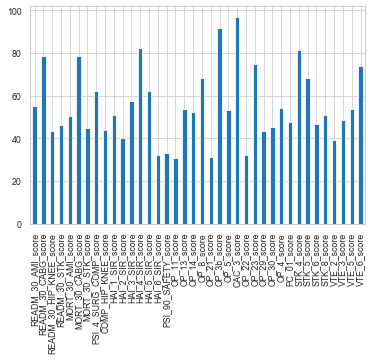

In [64]:
master_data_x = master_data_x.drop_duplicates(keep='first')
master_data_x
print_ln()

master_data_x.isnull().sum()

columns_with_missing_data = round(100 * (master_data_x.isnull().sum() / len(master_data_x.index)), 2)
columns_with_missing_data[columns_with_missing_data > 30].plot(kind='bar')
plt.show()

In [65]:

np.sum(master_data_x.isnull().sum().to_list())
print_ln()

master_data_x

-------------------------------------------------------------------------------- 



,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_CABG_score,...,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.615156,...,0.538880,-1.228236,-0.024906,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0.416331
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,NaN,...,0.324044,NaN,0.193305,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,NaN
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,-0.703937,...,0.538880,NaN,0.193305,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,0.416331
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,NaN,...,NaN,NaN,0.411517,-3.019716,NaN,0.333841,0.381176,NaN,NaN,NaN
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.489340,NaN,NaN,NaN,NaN
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,-0.843809,-0.526375,...,0.538880,-4.929290,NaN,-0.667976,-4.592380,-2.542886,-4.608052,-3.447662,0.635329,-3.876657
6,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,0.826243,NaN,...,-2.253994,NaN,NaN,-0.049098,0.618334,0.489340,0.214868,0.209952,0.635329,NaN
7,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,-0.843809,-1.236623,...,0.109207,NaN,0.193305,0.322230,0.435502,0.411590,0.381176,0.819555,0.368630,0.416331
8,10018,CALLAHAN EYE HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-7.207848,NaN,NaN,NaN,NaN
9,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,AL,35660,COLBERT,2563864556,NaN,NaN,...,-1.179812,NaN,-2.207021,-0.915528,-1.392818,0.178342,-0.450362,0.819555,0.635329,NaN


## Load the dependent variable i.e. the `rating` 

In [67]:
hospital_ratings = pd.read_csv("Hospital General Information.csv", encoding="ISO-8859-1", na_values=["Not Available", "Not Applicable"])
hospital_ratings.columns
print_ln()
hospital_ratings
print_ln()

master_data_y = hospital_ratings

hospital_ratings[['Hospital overall rating']].isnull().sum()

master_data_y = master_data_y.iloc[:,[0, 12]]
master_data_y.columns
print_ln()

master_data = pd.merge(master_data_x, master_data_y, on= "Provider ID")
master_data
print_ln()

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [68]:

master_data_without_na = master_data[master_data['Hospital overall rating'].notnull()]
master_data_without_na
print_ln()

master_data_without_na

master_data_with_na = master_data[~master_data['Hospital overall rating'].notnull()]
master_data_with_na
print_ln()

np.sum(master_data_without_na.isnull().sum().to_list())


-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



65783

In [69]:
columns_with_missing_data = round(100 * (master_data_without_na.isnull().sum() / len(master_data_without_na.index)), 2)

output = columns_with_missing_data[columns_with_missing_data < 50]
output = list(output.to_dict().keys())
print_ln()

master_data_without_na = master_data_without_na[output]
master_data_without_na

-------------------------------------------------------------------------------- 



,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_COPD_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.866907,...,0.071075,NaN,0.538880,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,3.0
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,1.574551,...,0.500302,0.545870,0.324044,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,3.0
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,0.156930,...,0.328611,NaN,0.538880,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,2.0
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,0.078174,...,-3.448585,-1.232556,NaN,-3.019716,NaN,0.333841,0.381176,NaN,NaN,3.0
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,0.629471,...,0.714915,NaN,NaN,NaN,NaN,0.489340,NaN,NaN,NaN,3.0
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,-0.843809,0.314444,...,-1.688755,NaN,0.538880,-0.667976,-4.592380,-2.542886,-4.608052,-3.447662,0.635329,2.0
6,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,0.826243,0.629471,...,0.843683,0.723713,-2.253994,-0.049098,0.618334,0.489340,0.214868,0.209952,0.635329,3.0
7,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,-0.843809,1.653308,...,0.843683,NaN,0.109207,0.322230,0.435502,0.411590,0.381176,0.819555,0.368630,3.0
9,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,AL,35660,COLBERT,2563864556,NaN,-2.363284,...,0.843683,0.545870,-1.179812,-0.915528,-1.392818,0.178342,-0.450362,0.819555,0.635329,2.0
10,10021,DALE MEDICAL CENTER,126 HOSPITAL AVE,OZARK,AL,36360,DALE,3347742601,NaN,0.078174,...,0.414456,0.723713,NaN,NaN,NaN,0.567089,0.547483,NaN,NaN,4.0


In [70]:
# Impute only relevant numerical columns
master_data_without_na.iloc[ : , 8:] =  master_data_without_na.iloc[ : , 8:].apply(lambda x: x.fillna(x.median()), axis=0)

master_data_without_na

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_COPD_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.866907,...,0.071075,0.368028,0.538880,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,3.0
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,1.574551,...,0.500302,0.545870,0.324044,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,3.0
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,0.156930,...,0.328611,0.368028,0.538880,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,2.0
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,0.095596,0.078174,...,-3.448585,-1.232556,0.324044,-3.019716,0.344086,0.333841,0.381176,0.331873,0.457530,3.0
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,0.095596,0.629471,...,0.714915,0.368028,0.324044,0.322230,0.344086,0.489340,0.381176,0.331873,0.457530,3.0
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,-0.843809,0.314444,...,-1.688755,0.368028,0.538880,-0.667976,-4.592380,-2.542886,-4.608052,-3.447662,0.635329,2.0
6,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,0.826243,0.629471,...,0.843683,0.723713,-2.253994,-0.049098,0.618334,0.489340,0.214868,0.209952,0.635329,3.0
7,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,-0.843809,1.653308,...,0.843683,0.368028,0.109207,0.322230,0.435502,0.411590,0.381176,0.819555,0.368630,3.0
9,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,AL,35660,COLBERT,2563864556,0.095596,-2.363284,...,0.843683,0.545870,-1.179812,-0.915528,-1.392818,0.178342,-0.450362,0.819555,0.635329,2.0
10,10021,DALE MEDICAL CENTER,126 HOSPITAL AVE,OZARK,AL,36360,DALE,3347742601,0.095596,0.078174,...,0.414456,0.723713,0.324044,0.322230,0.344086,0.567089,0.547483,0.331873,0.457530,4.0


In [71]:
master_data_without_na.isnull().sum()


Provider ID                0
Hospital Name              0
Address                    0
City                       0
State                      0
                          ..
VTE_1_score                0
VTE_2_score                0
VTE_3_score                0
VTE_5_score                0
Hospital overall rating    0
Length: 61, dtype: int64

In [72]:
master_data_without_na = master_data_without_na.drop(master_data_without_na.iloc[:, 1:8],  axis = 1)
master_data_without_na['Hospital overall rating'], factors_hospital_overall_rating =  pd.factorize(master_data_without_na['Hospital overall rating'])
cleaned_master_data = master_data_without_na
cleaned_master_data
print_ln()

cleaned_master_data.to_csv("cleaned_master_data_py.csv")

-------------------------------------------------------------------------------- 



# EDA - TODO

In [73]:
hospital_ratings['Hospital Type'].value_counts()


Acute Care Hospitals         3382
Critical Access Hospitals    1337
Childrens                      99
Name: Hospital Type, dtype: int64

In [74]:
hospital_ratings =  hospital_ratings[hospital_ratings['Hospital Type'] == 'Acute Care Hospitals']

hospital_ratings['Hospital Type'], factors_hospital_type =  pd.factorize(hospital_ratings['Hospital Type'])

hospital_ratings
print_ln()

hospital_ratings['Hospital overall rating'].value_counts()
hospital_ratings = func_numeric(hospital_ratings,'Hospital overall rating')


-------------------------------------------------------------------------------- 



In [75]:

hospital_ratings['Hospital Ownership'].value_counts()

print_ln()

hospital_ratings = hospital_ratings[hospital_ratings['Hospital Ownership'].notnull()]
hospital_ratings


-------------------------------------------------------------------------------- 



,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Readmission national comparison,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0,Government - Hospital District or Authority,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Same as the National average,NaN
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0,Government - Hospital District or Authority,...,Above the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Below the National average,NaN
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0,Government - Hospital District or Authority,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,0,Voluntary non-profit - Private,...,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,0,Proprietary,...,Same as the National average,NaN,NaN,Results are not available for this reporting p...,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,0,Voluntary non-profit - Private,...,Same as the National average,NaN,Below the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN
6,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,0,Proprietary,...,Same as the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN
7,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,0,Voluntary non-profit - Private,...,Above the National average,NaN,Below the National average,NaN,Above the National average,NaN,Below the National average,NaN,Below the National average,NaN
8,10018,CALLAHAN EYE HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,0,Voluntary non-profit - Private,...,NaN,Results are not available for this reporting p...,NaN,Results are not available for this reporting p...,Below the National average,NaN,Same as the National average,NaN,NaN,Results are not available for this reporting p...
9,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,AL,35660,COLBERT,2563864556,0,Government - Hospital District or Authority,...,Below the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Below the National average,NaN


In [76]:
#hospital_ratings.dtypes
#print_ln()

hospital_ratings = func_numeric(hospital_ratings, 'Hospital overall rating')
#hospital_ratings.dtypes
hospital_ratings[['State', 'Hospital overall rating']]
print_ln()

avg_by_state = hospital_ratings.groupby(['State'])['Hospital overall rating'].agg({'Hospital overall rating': np.mean })

avg_by_state = avg_by_state.sort_values(by=['Hospital overall rating'], ascending= False).reset_index()
avg_by_state

-------------------------------------------------------------------------------- 



,State,Hospital overall rating
0,SD,4.200000
1,WI,3.692308
2,DE,3.666667
3,ID,3.666667
4,IN,3.587500
5,MT,3.583333
6,NH,3.538462
7,KS,3.522727
8,MN,3.520833
9,CO,3.500000


-------------------------------------------------------------------------------- 



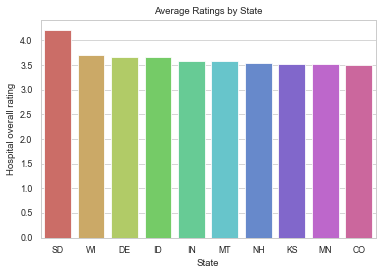

In [77]:
avg_by_state.head(10)
print_ln()

sns.barplot(x = 'State', y= "Hospital overall rating", data = avg_by_state.head(10), palette = 'hls')

plt.title("Average Ratings by State")
plt.show()

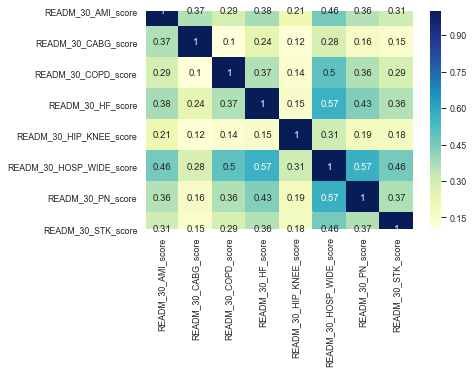

In [83]:
# correlation of readmission
readmission = read_master
readmission = readmission.drop(readmission.iloc[:, 0:8],  axis = 1)
readmission

corr_matrix = readmission.corr().abs()
sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True)


In [82]:

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.80
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.60)]

print("HIGHLY CORRELATED FEATURES IN DATA SET:{}\n\n{}".format(len(high_corr_features), high_corr_features))

HIGHLY CORRELATED FEATURES IN DATA SET:0

[]


## Model Building

In [84]:
# split into train and test
from sklearn.model_selection import train_test_split

#cleaned_master_data['Hospital overall rating'], factors_hospital_overall_rating =  pd.factorize(cleaned_master_data['Hospital overall rating'])

#cleaned_master_data = pd.get_dummies(cleaned_master_data['Hospital overall rating'], prefix='Hospital overall rating', drop_first=True)
cleaned_master_data

print_ln()

X = cleaned_master_data.loc[:, cleaned_master_data.columns != 'Hospital overall rating']
y = cleaned_master_data.loc[:, 'Hospital overall rating']

#from sklearn import preprocessing
#y = preprocessing.label_binarize(y, classes=[ 1, 2, 3, 4, 5])


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    train_size=0.7,
                                                    test_size=0.3, random_state=100)

X_train
print_ln()

X_test
print_ln()

y_train
print_ln()

y_test
print_ln()

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



## Random Forest Modelling

In [85]:
from sklearn.ensemble import RandomForestClassifier

model_rf1= RandomForestClassifier(n_estimators= 100)

#Train the model using the training sets y_pred=clf.predict(X_test)
model_rf1.fit(X_train, y_train)

y_pred= model_rf1.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


model_rf1_score = cross_val_score(model_rf1, X, y, cv=10)


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print_ln()

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print_ln()

print("=== All AUC Scores ===")
print(model_rf1_score)

print_ln()

print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", model_rf1_score.mean())
print_ln()


# TODO
# https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

Accuracy: 0.765296803652968
Mean Absolute Error: 0.38447488584474887
Mean Squared Error: 0.736986301369863
Root Mean Squared Error: 0.858479062860512
=== Confusion Matrix ===
[[494  16  22   0   0]
 [ 80 124   0   0   1]
 [ 84   0 205   1   0]
 [  0   0  25   8   0]
 [  0  28   0   0   7]]
-------------------------------------------------------------------------------- 

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       532
           1       0.74      0.60      0.66       205
           2       0.81      0.71      0.76       290
           3       0.89      0.24      0.38        33
           4       0.88      0.20      0.33        35

    accuracy                           0.77      1095
   macro avg       0.81      0.54      0.59      1095
weighted avg       0.77      0.77      0.75      1095

-------------------------------------------------------------------------------- 

=== All AUC Scores ===
[

In [86]:

from sklearn.ensemble import RandomForestClassifier

model_rf2= RandomForestClassifier(n_estimators= 1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
model_rf2.fit(X_train, y_train)

y_pred= model_rf2.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


model_rf2_score = cross_val_score(model_rf2, X, y, cv=10)


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print_ln()

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print_ln()

print("=== All AUC Scores ===")
print(model_rf2_score)

print_ln()

print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", model_rf2_score.mean())
print_ln()


Accuracy: 0.7863013698630137
Mean Absolute Error: 0.3497716894977169
Mean Squared Error: 0.6694063926940639
Root Mean Squared Error: 0.8181725934630565
=== Confusion Matrix ===
[[503  13  16   0   0]
 [ 75 130   0   0   0]
 [ 81   0 209   0   0]
 [  0   0  23  10   0]
 [  0  26   0   0   9]]
-------------------------------------------------------------------------------- 

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       532
           1       0.77      0.63      0.70       205
           2       0.84      0.72      0.78       290
           3       1.00      0.30      0.47        33
           4       1.00      0.26      0.41        35

    accuracy                           0.79      1095
   macro avg       0.88      0.57      0.64      1095
weighted avg       0.80      0.79      0.77      1095

-------------------------------------------------------------------------------- 

=== All AUC Scores ===

In [87]:


from sklearn.ensemble import RandomForestClassifier

model_rf3= RandomForestClassifier(n_estimators= 1500)

#Train the model using the training sets y_pred=clf.predict(X_test)
model_rf3.fit(X_train, y_train)

y_pred= model_rf3.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


model_rf3_score = cross_val_score(model_rf3, X, y, cv=10)


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print_ln()

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print_ln()

print("=== All AUC Scores ===")
print(model_rf2_score)

print_ln()

print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", model_rf3_score.mean())
print_ln()



Accuracy: 0.7853881278538812
Mean Absolute Error: 0.3515981735159817
Mean Squared Error: 0.6730593607305936
Root Mean Squared Error: 0.8204019507111094
=== Confusion Matrix ===
[[505  10  17   0   0]
 [ 79 126   0   0   0]
 [ 81   0 209   0   0]
 [  0   0  22  11   0]
 [  0  26   0   0   9]]
-------------------------------------------------------------------------------- 

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       532
           1       0.78      0.61      0.69       205
           2       0.84      0.72      0.78       290
           3       1.00      0.33      0.50        33
           4       1.00      0.26      0.41        35

    accuracy                           0.79      1095
   macro avg       0.88      0.58      0.64      1095
weighted avg       0.80      0.79      0.77      1095

-------------------------------------------------------------------------------- 

=== All AUC Scores ===

## PCA

In [89]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


In [91]:
cleaned_master_data = pd.read_csv("cleaned_master_data_py.csv")
cleaned_master_data.drop(['Unnamed: 0'], inplace= True, axis=1)
cleaned_master_data.head()

,Provider ID,READM_30_AMI_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score,MORT_30_AMI_score,MORT_30_COPD_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
0,10001,0.408730,-0.866907,0.370423,-0.884170,0.215408,-1.105482,-0.124569,1.249515,-1.094132,...,0.071075,0.368028,0.538880,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0
1,10005,0.199974,1.574551,0.036453,-1.968440,0.820649,0.495640,-0.777118,-1.546065,0.434008,...,0.500302,0.545870,0.324044,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,0
2,10006,0.826243,0.156930,0.904776,-0.703459,0.215408,-0.548570,0.527980,-2.105181,0.883461,...,0.328611,0.368028,0.538880,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,1
3,10007,0.095596,0.078174,0.570805,0.019388,-1.237171,-0.130886,-0.124569,0.051410,-1.094132,...,-3.448585,-1.232556,0.324044,-3.019716,0.344086,0.333841,0.381176,0.331873,0.457530,0
4,10008,0.095596,0.629471,-0.765075,0.019388,-0.147737,0.774096,0.061873,0.051410,-0.105335,...,0.714915,0.368028,0.324044,0.322230,0.344086,0.489340,0.381176,0.331873,0.457530,0


In [92]:
cleaned_master_data.columns

Index(['Provider ID', 'READM_30_AMI_score', 'READM_30_COPD_score',
       'READM_30_HF_score', 'READM_30_HIP_KNEE_score',
       'READM_30_HOSP_WIDE_score', 'READM_30_PN_score', 'READM_30_STK_score',
       'MORT_30_AMI_score', 'MORT_30_COPD_score', 'MORT_30_HF_score',
       'MORT_30_PN_score', 'MORT_30_STK_score', 'COMP_HIP_KNEE_score',
       'HAI_1_SIR_score', 'HAI_2_SIR_score', 'HAI_3_SIR_score',
       'HAI_6_SIR_score', 'PSI_90_SAFETY_score', 'H_CLEAN_LINEAR_SCORE_score',
       'H_COMP_1_LINEAR_SCORE_score', 'H_COMP_2_LINEAR_SCORE_score',
       'H_COMP_3_LINEAR_SCORE_score', 'H_COMP_4_LINEAR_SCORE_score',
       'H_COMP_5_LINEAR_SCORE_score', 'H_COMP_6_LINEAR_SCORE_score',
       'H_COMP_7_LINEAR_SCORE_score', 'H_HSP_RATING_LINEAR_SCORE_score',
       'H_QUIET_LINEAR_SCORE_score', 'H_RECMND_LINEAR_SCORE_score',
       'OP_10_score', 'OP_11_score', 'OP_13_score', 'OP_14_score',
       'ED_1b_score', 'ED_2b_score', 'OP_18b_score', 'OP_20_score',
       'OP_21_score', 'OP_5_score

In [93]:
cleaned_master_data.shape

(3648, 54)

In [95]:
cleaned_master_data.describe(percentiles=[.25,.5,.75,.90,.95,.99])


,Provider ID,READM_30_AMI_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score,MORT_30_AMI_score,MORT_30_COPD_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
count,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,...,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000
mean,264497.236294,0.040316,0.011140,0.004741,0.006706,-0.000939,-0.013489,0.020016,0.018961,0.004194,...,0.128376,0.186334,0.123164,0.107794,0.138350,0.108543,0.099985,0.113131,0.187199,0.935581
std,157276.680884,0.755860,0.965464,0.968790,0.835301,1.030625,1.000049,0.828295,0.794316,0.966671,...,0.848641,0.699205,0.706634,0.809407,0.745856,0.751082,0.790766,0.808478,0.785138,1.075420
min,10001.000000,-3.453265,-4.017174,-3.303249,-3.775556,-3.900231,-3.750815,-3.853419,-3.622782,-3.970632,...,-3.448585,-5.856466,-7.624905,-7.351867,-8.066189,-7.207848,-7.767896,-5.276469,-6.121062,0.000000
25%,140014.500000,-0.113161,-0.551880,-0.564693,-0.342035,-0.631929,-0.618184,-0.217790,-0.268085,-0.464898,...,0.028152,0.190185,0.109207,0.198454,0.161254,0.022843,0.048561,0.088032,0.279730,0.000000
50%,260018.500000,0.095596,0.078174,0.036453,0.019388,0.094360,0.077956,0.061873,0.051410,0.074446,...,0.414456,0.368028,0.324044,0.322230,0.344086,0.333841,0.381176,0.331873,0.457530,1.000000
75%,390113.250000,0.199974,0.629471,0.637599,0.380811,0.608815,0.634868,0.434758,0.291031,0.613789,...,0.629070,0.368028,0.538880,0.446005,0.435502,0.489340,0.547483,0.575714,0.635329,2.000000
90%,460054.900000,0.826243,1.180768,1.171952,0.922946,1.183794,1.191780,0.994086,1.009894,1.153133,...,0.843683,0.723713,0.538880,0.569781,0.618334,0.567089,0.547483,0.819555,0.635329,2.000000
95%,510056.950000,1.348135,1.574551,1.572716,1.465081,1.546938,1.470236,1.273750,1.329389,1.422805,...,0.843683,0.723713,0.538880,0.569781,0.618334,0.567089,0.547483,0.819555,0.635329,3.000000
99%,594217.640000,2.183161,2.204605,2.240656,2.007216,2.394276,2.064044,1.926299,2.048253,2.052039,...,0.843683,0.723713,0.538880,0.569781,0.618334,0.567089,0.547483,0.819555,0.635329,4.000000


In [96]:

cleaned_master_data_numerical_values = cleaned_master_data.drop(['Provider ID'], axis=1)
cleaned_master_data_numerical_values.head()



,READM_30_AMI_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score,MORT_30_AMI_score,MORT_30_COPD_score,MORT_30_HF_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
0,0.408730,-0.866907,0.370423,-0.884170,0.215408,-1.105482,-0.124569,1.249515,-1.094132,-0.165556,...,0.071075,0.368028,0.538880,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0
1,0.199974,1.574551,0.036453,-1.968440,0.820649,0.495640,-0.777118,-1.546065,0.434008,-2.286446,...,0.500302,0.545870,0.324044,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,0
2,0.826243,0.156930,0.904776,-0.703459,0.215408,-0.548570,0.527980,-2.105181,0.883461,-2.354862,...,0.328611,0.368028,0.538880,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,1
3,0.095596,0.078174,0.570805,0.019388,-1.237171,-0.130886,-0.124569,0.051410,-1.094132,-1.533872,...,-3.448585,-1.232556,0.324044,-3.019716,0.344086,0.333841,0.381176,0.331873,0.457530,0
4,0.095596,0.629471,-0.765075,0.019388,-0.147737,0.774096,0.061873,0.051410,-0.105335,-0.370803,...,0.714915,0.368028,0.324044,0.322230,0.344086,0.489340,0.381176,0.331873,0.457530,0


In [90]:
## Outlier Detection via IQR Method


In [97]:
#IQR method:
Q1 = cleaned_master_data_numerical_values.quantile(0.25)
Q1

READM_30_AMI_score                -0.113161
READM_30_COPD_score               -0.551880
READM_30_HF_score                 -0.564693
READM_30_HIP_KNEE_score           -0.342035
READM_30_HOSP_WIDE_score          -0.631929
READM_30_PN_score                 -0.618184
READM_30_STK_score                -0.217790
MORT_30_AMI_score                 -0.268085
MORT_30_COPD_score                -0.464898
MORT_30_HF_score                  -0.576051
MORT_30_PN_score                  -0.575290
MORT_30_STK_score                 -0.282062
COMP_HIP_KNEE_score               -0.282949
HAI_1_SIR_score                   -0.064065
HAI_2_SIR_score                   -0.293496
HAI_3_SIR_score                    0.053201
HAI_6_SIR_score                   -0.477437
PSI_90_SAFETY_score               -0.288631
H_CLEAN_LINEAR_SCORE_score        -0.593858
H_COMP_1_LINEAR_SCORE_score       -0.523620
H_COMP_2_LINEAR_SCORE_score       -0.368082
H_COMP_3_LINEAR_SCORE_score       -0.517566
H_COMP_4_LINEAR_SCORE_score     

In [99]:

Q3 = cleaned_master_data_numerical_values.quantile(0.75)
Q3

READM_30_AMI_score                 0.199974
READM_30_COPD_score                0.629471
READM_30_HF_score                  0.637599
READM_30_HIP_KNEE_score            0.380811
READM_30_HOSP_WIDE_score           0.608815
READM_30_PN_score                  0.634868
READM_30_STK_score                 0.434758
MORT_30_AMI_score                  0.291031
MORT_30_COPD_score                 0.613789
MORT_30_HF_score                   0.587018
MORT_30_PN_score                   0.666514
MORT_30_STK_score                  0.439197
COMP_HIP_KNEE_score                0.431897
HAI_1_SIR_score                    0.346930
HAI_2_SIR_score                    0.552122
HAI_3_SIR_score                    0.260121
HAI_6_SIR_score                    0.494114
PSI_90_SAFETY_score                0.518834
H_CLEAN_LINEAR_SCORE_score         0.700892
H_COMP_1_LINEAR_SCORE_score        0.659669
H_COMP_2_LINEAR_SCORE_score        0.450449
H_COMP_3_LINEAR_SCORE_score        0.619898
H_COMP_4_LINEAR_SCORE_score     

In [100]:

IQR = Q3 - Q1
IQR

READM_30_AMI_score                 0.313135
READM_30_COPD_score                1.181350
READM_30_HF_score                  1.202293
READM_30_HIP_KNEE_score            0.722847
READM_30_HOSP_WIDE_score           1.240744
READM_30_PN_score                  1.253052
READM_30_STK_score                 0.652549
MORT_30_AMI_score                  0.559116
MORT_30_COPD_score                 1.078687
MORT_30_HF_score                   1.163069
MORT_30_PN_score                   1.241803
MORT_30_STK_score                  0.721259
COMP_HIP_KNEE_score                0.714846
HAI_1_SIR_score                    0.410994
HAI_2_SIR_score                    0.845618
HAI_3_SIR_score                    0.206920
HAI_6_SIR_score                    0.971551
PSI_90_SAFETY_score                0.807465
H_CLEAN_LINEAR_SCORE_score         1.294750
H_COMP_1_LINEAR_SCORE_score        1.183289
H_COMP_2_LINEAR_SCORE_score        0.818531
H_COMP_3_LINEAR_SCORE_score        1.137464
H_COMP_4_LINEAR_SCORE_score     

In [102]:
### Normalizing the dataset

In [103]:

normalization_df=(cleaned_master_data_numerical_values < (Q1 - 1.5 * IQR)) | (cleaned_master_data_numerical_values > (Q3 + 1.5 * IQR))
normalization_df.head()

,READM_30_AMI_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score,MORT_30_AMI_score,MORT_30_COPD_score,MORT_30_HF_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
0,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
1,False,False,False,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
2,True,False,False,False,False,False,False,True,False,True,...,False,False,False,False,True,False,True,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,True,True,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [104]:
normalization_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3648 entries, 0 to 3647
Data columns (total 53 columns):
READM_30_AMI_score                 3648 non-null bool
READM_30_COPD_score                3648 non-null bool
READM_30_HF_score                  3648 non-null bool
READM_30_HIP_KNEE_score            3648 non-null bool
READM_30_HOSP_WIDE_score           3648 non-null bool
READM_30_PN_score                  3648 non-null bool
READM_30_STK_score                 3648 non-null bool
MORT_30_AMI_score                  3648 non-null bool
MORT_30_COPD_score                 3648 non-null bool
MORT_30_HF_score                   3648 non-null bool
MORT_30_PN_score                   3648 non-null bool
MORT_30_STK_score                  3648 non-null bool
COMP_HIP_KNEE_score                3648 non-null bool
HAI_1_SIR_score                    3648 non-null bool
HAI_2_SIR_score                    3648 non-null bool
HAI_3_SIR_score                    3648 non-null bool
HAI_6_SIR_score              

In [106]:
cleaned_master_data_normalized = cleaned_master_data[~normalization_df.any(axis=1)]
cleaned_master_data_normalized.head()


,Provider ID,READM_30_AMI_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score,MORT_30_AMI_score,MORT_30_COPD_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
14,10032,0.095596,1.102011,0.236835,0.019388,0.820649,0.565254,0.061873,0.051410,-0.105335,...,0.843683,0.012342,0.324044,0.322230,0.344086,0.256092,0.381176,0.331873,0.457530,2
153,40018,0.095596,-0.315610,0.103247,0.019388,0.699601,0.495640,0.061873,0.051410,0.793571,...,0.414456,0.012342,0.324044,0.322230,0.344086,0.489340,0.381176,0.331873,0.457530,0
192,41322,0.095596,-0.709393,-0.965457,0.019388,-0.874026,-1.383938,-0.497454,0.051410,-1.184023,...,0.414456,0.368028,0.324044,0.322230,0.344086,0.333841,0.381176,0.331873,0.457530,1
233,50073,0.199974,0.078174,-0.297517,0.019388,-0.268785,-0.966254,-0.031348,0.211157,0.074446,...,0.414456,0.368028,0.538880,0.322230,0.435502,-0.210405,0.547483,0.331873,0.457530,0
271,50137,0.095596,0.078174,0.036453,0.019388,0.215408,0.077956,0.061873,0.051410,0.074446,...,0.414456,0.368028,0.324044,0.569781,0.618334,0.489340,0.381176,0.819555,0.635329,0


In [107]:
cleaned_master_data_normalized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 14 to 3635
Data columns (total 54 columns):
Provider ID                        134 non-null int64
READM_30_AMI_score                 134 non-null float64
READM_30_COPD_score                134 non-null float64
READM_30_HF_score                  134 non-null float64
READM_30_HIP_KNEE_score            134 non-null float64
READM_30_HOSP_WIDE_score           134 non-null float64
READM_30_PN_score                  134 non-null float64
READM_30_STK_score                 134 non-null float64
MORT_30_AMI_score                  134 non-null float64
MORT_30_COPD_score                 134 non-null float64
MORT_30_HF_score                   134 non-null float64
MORT_30_PN_score                   134 non-null float64
MORT_30_STK_score                  134 non-null float64
COMP_HIP_KNEE_score                134 non-null float64
HAI_1_SIR_score                    134 non-null float64
HAI_2_SIR_score                    134 non-null float64

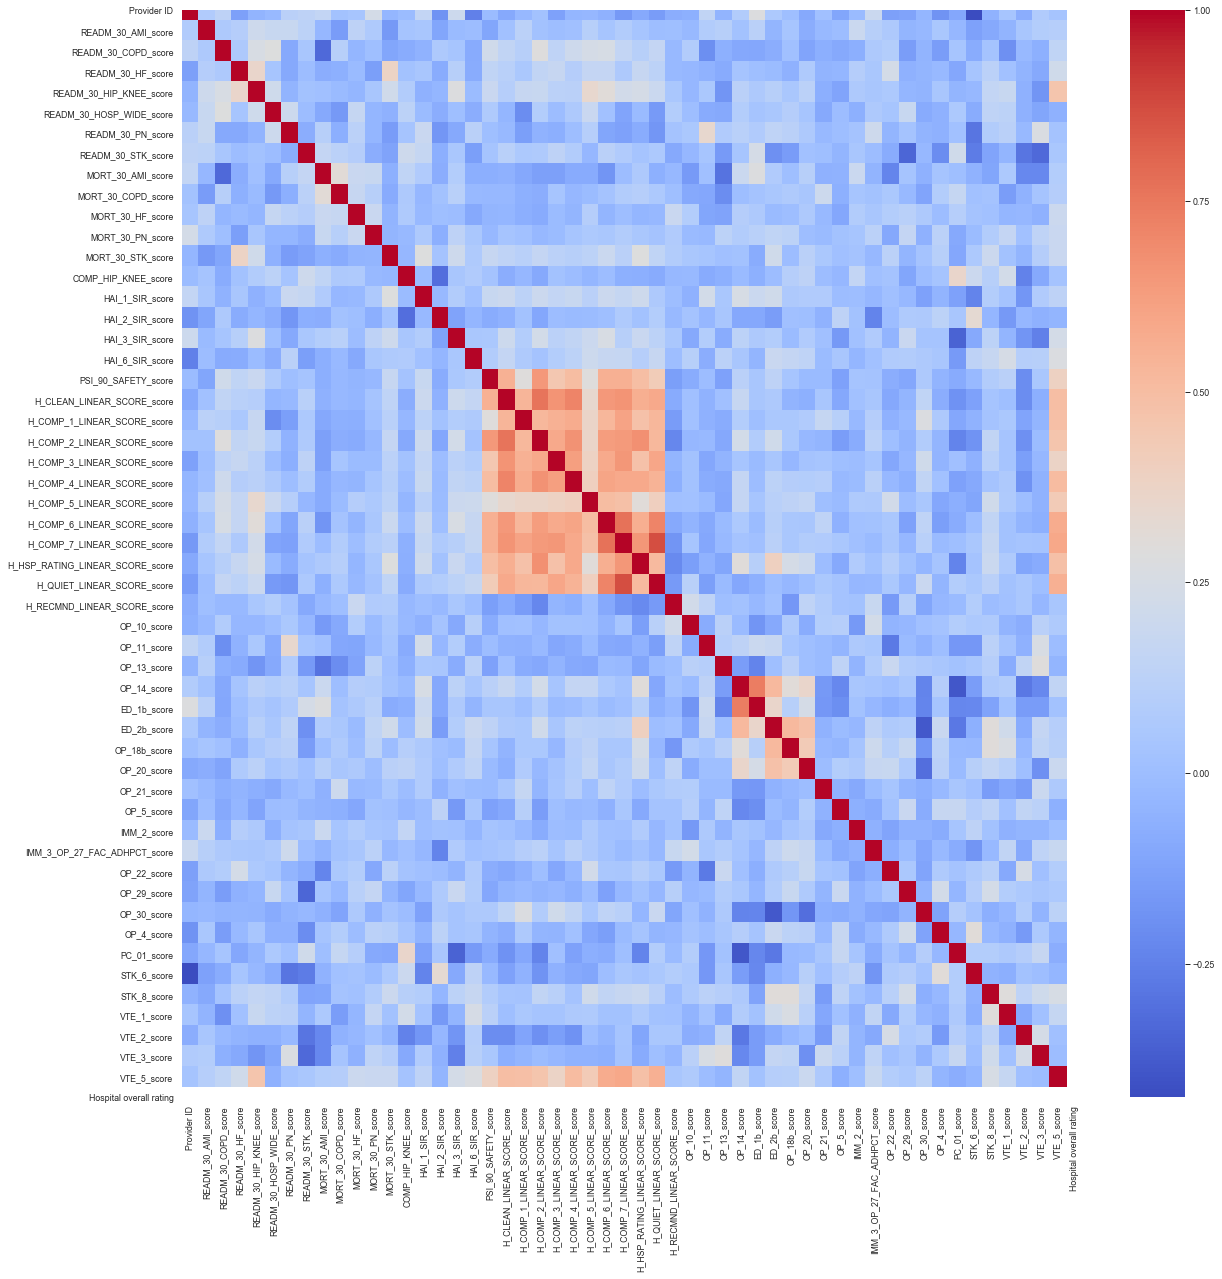

In [110]:

%matplotlib inline
plt.figure(figsize = (20,20))

df = np.corrcoef(cleaned_master_data_normalized.drop(['Provider ID'], axis=1).transpose())

sns.heatmap(df, \
            cmap='coolwarm', \
            xticklabels=cleaned_master_data_normalized.columns, \
            yticklabels=cleaned_master_data_normalized.columns)

In [111]:

df = cleaned_master_data_numerical_values


# Putting feature variable to X
X = df.drop(['Hospital overall rating'],axis=1)

# Putting response variable to y
y = df['Hospital overall rating']




In [112]:
X_train, X_test, y_train, y_test = train_test_split(X,y, \
                                                    train_size=0.7, \
                                                    test_size=0.3, \
                                                    random_state=100)




In [113]:

pca = PCA(svd_solver='randomized', random_state=16)

pca.fit(X_train)

pca.components_



array([[-0.06566319, -0.08802398, -0.1271059 , ..., -0.02112645,
        -0.0477657 , -0.05155829],
       [-0.20290728, -0.31249011, -0.34655075, ...,  0.03679429,
         0.00728559,  0.022809  ],
       [ 0.0946004 ,  0.12303294,  0.17437129, ...,  0.01791973,
        -0.00324202, -0.10008102],
       ...,
       [-0.02208118, -0.00217902, -0.00227344, ..., -0.01316967,
         0.00869921,  0.0117365 ],
       [ 0.00517571, -0.02293308,  0.02127362, ...,  0.0197287 ,
        -0.01788975, -0.00768316],
       [ 0.00388085, -0.00152768, -0.00167609, ..., -0.00291331,
        -0.00787017,  0.01346795]])

In [114]:

colnames = list(X_train.columns)

pcs_df = pd.DataFrame({'PC1':pca.components_[0],\
                       'PC2':pca.components_[1], \
                       'Feature':colnames})

pcs_df.head()




,PC1,PC2,Feature
0,-0.065663,-0.202907,READM_30_AMI_score
1,-0.088024,-0.312490,READM_30_COPD_score
2,-0.127106,-0.346551,READM_30_HF_score
3,-0.052989,-0.161202,READM_30_HIP_KNEE_score
4,-0.164051,-0.441659,READM_30_HOSP_WIDE_score


In [115]:

explained_variance_ratio_ = np.around(pca.explained_variance_ratio_, decimals = 3)
explained_variance_ratio_


array([0.204, 0.064, 0.059, 0.047, 0.04 , 0.027, 0.027, 0.025, 0.023,
       0.022, 0.021, 0.019, 0.018, 0.018, 0.017, 0.016, 0.016, 0.015,
       0.015, 0.015, 0.014, 0.014, 0.014, 0.013, 0.013, 0.012, 0.012,
       0.012, 0.012, 0.011, 0.011, 0.011, 0.011, 0.01 , 0.01 , 0.01 ,
       0.009, 0.009, 0.009, 0.009, 0.009, 0.008, 0.008, 0.007, 0.007,
       0.006, 0.005, 0.004, 0.004, 0.002, 0.002, 0.001])

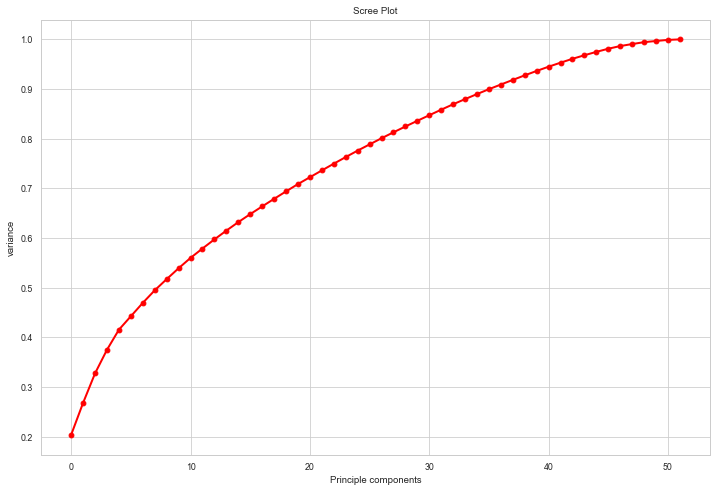

In [116]:
# scree plot
%matplotlib inline

fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principle components')
plt.ylabel('variance')
plt.show()

In [117]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=2)

df_pca = pca_final.fit_transform(cleaned_master_data.drop(['Provider ID'], axis=1))
df_pca.shape

(3648, 2)

In [118]:

pc = np.transpose(df_pca)

pc_df = pd.DataFrame({'PC1':pc[0],'PC2':pc[1]})
pc_df.head()

,PC1,PC2
0,-1.677849,-1.313947
1,0.822836,1.839886
2,-0.619815,2.113933
3,0.773723,3.560533
4,0.764826,1.136766


In [119]:
pc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3648 entries, 0 to 3647
Data columns (total 2 columns):
PC1    3648 non-null float64
PC2    3648 non-null float64
dtypes: float64(2)
memory usage: 57.1 KB


In [120]:
pc_df.index = cleaned_master_data['Provider ID']
pc_df.head()


,PC1,PC2
Provider ID,,
10001,-1.677849,-1.313947
10005,0.822836,1.839886
10006,-0.619815,2.113933
10007,0.773723,3.560533
10008,0.764826,1.136766


## Clustering via K-means

In [121]:

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

# Defining a hopkins function to check the suitability of the data.
def hopkins(X):
    d = X.shape[1]

    n = len(X)
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0

    return H


In [122]:

pc_df.head()

,PC1,PC2
Provider ID,,
10001,-1.677849,-1.313947
10005,0.822836,1.839886
10006,-0.619815,2.113933
10007,0.773723,3.560533
10008,0.764826,1.136766


In [123]:

print('With ',round(hopkins(pc_df),2),'hopkins statistic it is indicating data is nicely clustered')

With  0.9 hopkins statistic it is indicating data is nicely clustered


In [124]:
df_kmean = pc_df
df_kmean.head()

,PC1,PC2
Provider ID,,
10001,-1.677849,-1.313947
10005,0.822836,1.839886
10006,-0.619815,2.113933
10007,0.773723,3.560533
10008,0.764826,1.136766


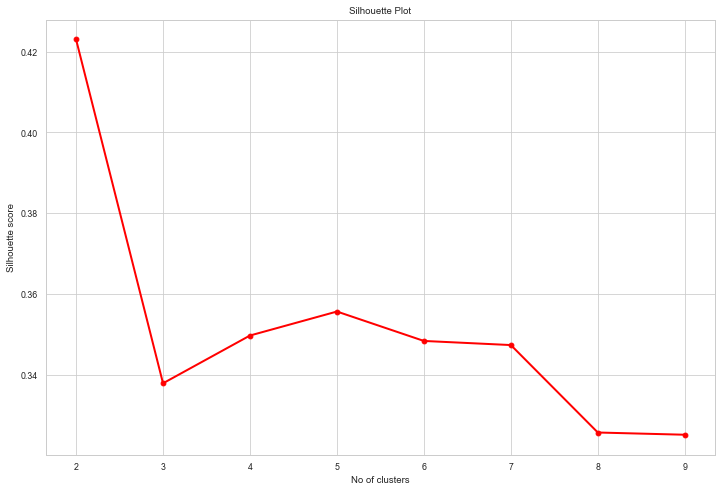

In [126]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(df_kmean)
    sse_.append([k, silhouette_score(df_kmean, kmeans.labels_)])

    
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1], 'ro-', linewidth=2);
plt.title('Silhouette Plot')
plt.xlabel('No of clusters')
plt.ylabel('Silhouette score')
plt.show()

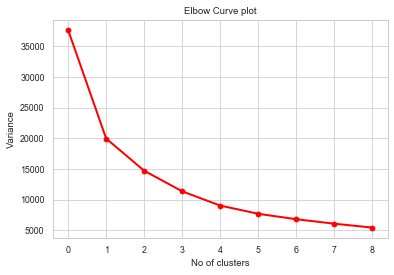

In [127]:

# Elbow curve method

ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(df_kmean)
    ssd.append(model_clus.inertia_)


plt.plot(ssd, 'ro-', linewidth=2);
plt.title('Elbow Curve plot')
plt.xlabel('No of clusters')
plt.ylabel('Variance')
plt.show()

## k = 4

In [130]:
kmean_model = KMeans(n_clusters = 4, max_iter=50,random_state = 50)
kmean_model.fit(df_kmean)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [131]:
kmean2_df=df_kmean
kmean2_df.index = pd.RangeIndex(len(kmean2_df.index))
kmean2_df2 = pd.concat([kmean2_df, pd.Series(kmean_model.labels_)], axis=1)
kmean2_df2.columns = ['PC1', 'PC2','ClusterID']
kmean2_df2.head()


,PC1,PC2,ClusterID
0,-1.677849,-1.313947,0
1,0.822836,1.839886,1
2,-0.619815,2.113933,1
3,0.773723,3.560533,1
4,0.764826,1.136766,1


In [132]:

kmean2_df2['ClusterID'].value_counts()

1    1275
0     861
3     845
2     667
Name: ClusterID, dtype: int64

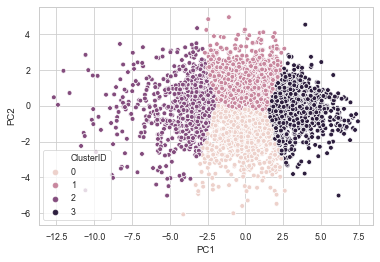

In [133]:

sns.scatterplot(x='PC1',y='PC2',hue='ClusterID',legend='full',data=kmean2_df2)

In [134]:
kmean_test2 = df_kmean
kmean_test2.head()

,PC1,PC2
0,-1.677849,-1.313947
1,0.822836,1.839886
2,-0.619815,2.113933
3,0.773723,3.560533
4,0.764826,1.136766


## K = 5

In [136]:
kmean_model2 = KMeans(n_clusters = 5, max_iter=50,random_state = 50)
kmean_model2.fit(kmean_test2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [137]:
kmean2_test_df=df_kmean
kmean2_test_df.index = pd.RangeIndex(len(kmean2_test_df.index))
kmean2_test2_df = pd.concat([kmean2_test_df, pd.Series(kmean_model2.labels_)], axis=1)
kmean2_test2_df.columns = ['PC1', 'PC2','ClusterID']
kmean2_test2_df.head()

,PC1,PC2,ClusterID
0,-1.677849,-1.313947,4
1,0.822836,1.839886,3
2,-0.619815,2.113933,3
3,0.773723,3.560533,3
4,0.764826,1.136766,3


In [138]:

kmean2_test2_df['ClusterID'].value_counts()

3    1154
4     762
2     745
0     687
1     300
Name: ClusterID, dtype: int64

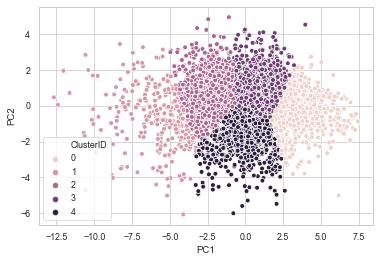

In [139]:
sns.scatterplot(x='PC1',y='PC2',hue='ClusterID',legend='full',data=kmean2_test2_df)


### Merge  K-mean dataset with original one and analyze the clusters to find out cluster representation of various features




In [140]:

kmean2_test2_df['Provider ID'] = cleaned_master_data['Provider ID']

kmean2_test2_df.head()

,PC1,PC2,ClusterID,Provider ID
0,-1.677849,-1.313947,4,10001
1,0.822836,1.839886,3,10005
2,-0.619815,2.113933,3,10006
3,0.773723,3.560533,3,10007
4,0.764826,1.136766,3,10008


In [141]:

kmean2_test2_df = pd.merge(kmean2_test2_df, cleaned_master_data ,on='Provider ID')
kmean2_test2_df.head()

,PC1,PC2,ClusterID,Provider ID,READM_30_AMI_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
0,-1.677849,-1.313947,4,10001,0.408730,-0.866907,0.370423,-0.884170,0.215408,-1.105482,...,0.071075,0.368028,0.538880,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0
1,0.822836,1.839886,3,10005,0.199974,1.574551,0.036453,-1.968440,0.820649,0.495640,...,0.500302,0.545870,0.324044,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,0
2,-0.619815,2.113933,3,10006,0.826243,0.156930,0.904776,-0.703459,0.215408,-0.548570,...,0.328611,0.368028,0.538880,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,1
3,0.773723,3.560533,3,10007,0.095596,0.078174,0.570805,0.019388,-1.237171,-0.130886,...,-3.448585,-1.232556,0.324044,-3.019716,0.344086,0.333841,0.381176,0.331873,0.457530,0
4,0.764826,1.136766,3,10008,0.095596,0.629471,-0.765075,0.019388,-0.147737,0.774096,...,0.714915,0.368028,0.324044,0.322230,0.344086,0.489340,0.381176,0.331873,0.457530,0


In [142]:
kmean2_test2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3648 entries, 0 to 3647
Data columns (total 57 columns):
PC1                                3648 non-null float64
PC2                                3648 non-null float64
ClusterID                          3648 non-null int32
Provider ID                        3648 non-null int64
READM_30_AMI_score                 3648 non-null float64
READM_30_COPD_score                3648 non-null float64
READM_30_HF_score                  3648 non-null float64
READM_30_HIP_KNEE_score            3648 non-null float64
READM_30_HOSP_WIDE_score           3648 non-null float64
READM_30_PN_score                  3648 non-null float64
READM_30_STK_score                 3648 non-null float64
MORT_30_AMI_score                  3648 non-null float64
MORT_30_COPD_score                 3648 non-null float64
MORT_30_HF_score                   3648 non-null float64
MORT_30_PN_score                   3648 non-null float64
MORT_30_STK_score                  3648 no

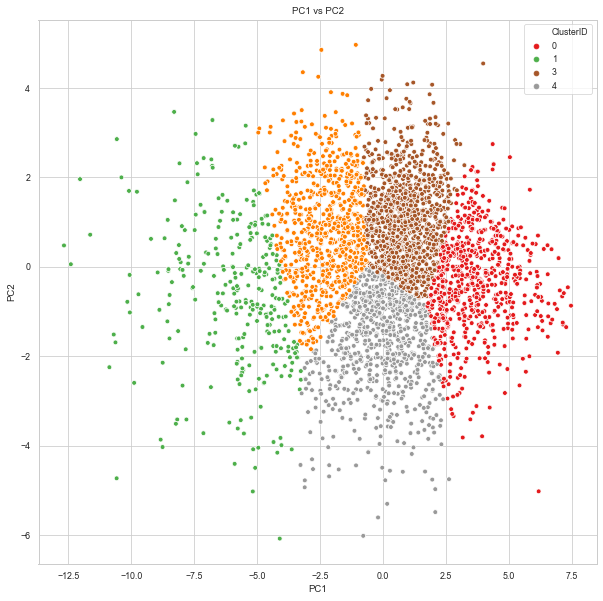

In [145]:
plt.figure(figsize=(10,10))
plt.title('PC1 vs PC2')
sns.scatterplot(x=kmean2_test2_df['PC1'],y=kmean2_test2_df['PC2'],hue=kmean2_test2_df.ClusterID, palette='Set1')
plt.show()

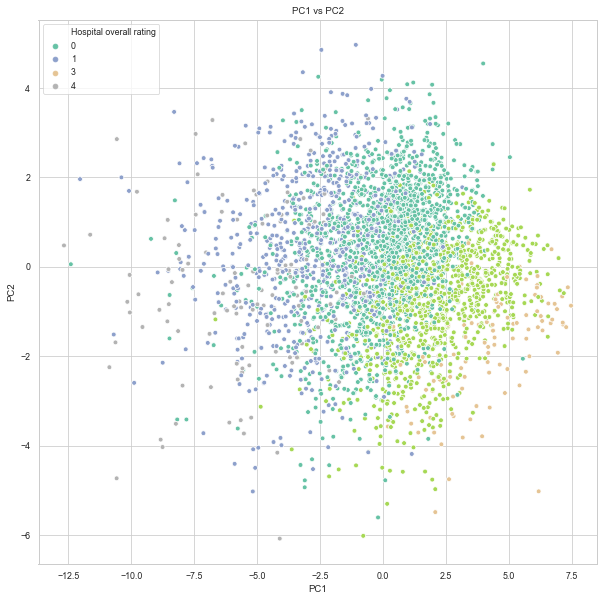

In [144]:
plt.figure(figsize=(10,10))
plt.title('PC1 vs PC2')
sns.scatterplot(x=kmean2_test2_df['PC1'], y=kmean2_test2_df['PC2'], hue=kmean2_test2_df['Hospital overall rating'], palette='Set2')
plt.show()